<a href="https://colab.research.google.com/github/bikash119/argilla_autotrain/blob/main/token_classification_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning a token classification model using Argilla Dataset and HuggingFace AutoTrain

We all would want to try out to solve some use case with a neat tool / techs available out there.
In this tutorial , I want to go over my learning journey to fine tune a model on US Patent text.

## Data Background





US Patent texts are typically long, descriptive documents about inventions. The data used in this tutorial can be accessed through the [Kaggle USPTO Competition](https://www.kaggle.com/competitions/uspto-explainable-ai). Each patent contains several fields:
- Title
- Abstract
- Claims
- Description

For this tutorial, we'll focus on the `claims` field.

## Problem Statement


  Our goal is to fine-tune a model to classify tokens in the `claims` field of a given patent.

## Breaking Down the Problem


To achieve this goal, we need:

1. High-quality data to fine-tune a pretrained token classification model
2. Infrastructure to execute the training

## Create High-Quality Data with Argilla
  [Argilla](https://github.com/argilla-io/argilla/) is an excellent tool for creating high-quality datasets with a user-friendly interface for labeling.
  


### Setting Up Argilla on Hugging Face Spaces

#### 1. Visit [Hugging Face Spaces deployment page](https://huggingface.co/new-space?template=argilla/argilla-template-space)

#### 2. Create a new space:
  - Provide a name
  - Select `Docker` as Space SDK
  - Choose `Argilla` as Docker Template
  - Leave other fields empty for simplicity
  - Click on `Create Space`

#### 3. Update the Dockerfile:
  - Go to `https://huggingface.co/spaces/<hf-username>/<space-name>/blob/main/Dockerfile`
  - Change `FROM argilla/argilla-quickstart:v1.29.0` to `FROM argilla/argilla-quickstart:v2.0.0rc2`

#### 4. Restart the Space

Now you have an Argilla instance running on Hugging Face Spaces. Click on the space you created to go to the login screen of Argilla UI.
Access the UI using the credentials:

- Username: `admin`
- Password: `12345678`

### Create a Dataset with Argilla Python SDK

#### Step 1: Install & Import packages

In [ ]:
!pip install -qqqU datasets argilla --pre autotrain-advanced &> /dev/null

In [ ]:
import argilla as rg
import pandas as pd
import re
import os
import random
import torch
from IPython.display import Image, display
from datasets import load_dataset, Dataset, DatasetDict,ClassLabel,Sequence,Value,Features
from transformers import pipeline,TokenClassificationPipeline
from typing import List, Dict, Union,Tuple
from google.colab import userdata

#### Step 2: Initialize the Argilla Client
api_url: We can get this URL by using the `https://huggingface.co/spaces/<hf_username>/<hf_space_name>?embed=true`


In [ ]:
DEBUG=False

In [ ]:
client = rg.Argilla(
    api_url="https://bikashpatra-argilla-uspto-labelling.hf.space",
    #api_url="https://<hf_username>-<hf_space_name>.hf.space # This is url to my public space.
    api_key="admin.apikey", # default value. Shouldn't be used for production.
    # headers={"Authorization": f"Bearer {HF_TOKEN}"}
)
#Replace `<hf-username>` and `<space-name>` with your actual Hugging Face username and space name.

#### Step 3: Configure the Dataset
To configure an Argilla dataset for token classification task, we will have to

1. Come up with labels specific to our problem domain: I came up with some labels by using the following prompt
 >suggest me some labels like "Process", "Product", "Composition of Matter" which can be used to annotate tokens in the claims or description section of patents filed in US

2. We need to configure fields/columns of our dataset and [`questions`](https://docs.argilla.io/latest/how_to_guides/dataset/#questions). The `questions` parameter allows you to instruct /guide the annotator on the task.In our usecase, we shall use `labels` we created for the annotators to select when annotating pieces (tokens) of text.


In [ ]:
# Labels for token classification
labels = [
    "Process", "Product", "Composition of Matter", "Method of Use",
    "Software", "Hardware", "Algorithm", "System", "Device",
    "Apparatus", "Method", "Machine", "Manufacture", "Design",
    "Pharmaceutical Formulation", "Biotechnology", "Chemical Compound",
    "Electrical Circuit"
]

# Dataset settings
settings = rg.Settings(
    guidelines="Classify individual tokens according to the specified categories, ensuring that any overlapping or nested entities are accurately captured.",
    fields=[
        rg.TextField(name="tokens", title="Text", use_markdown=True),
        rg.TextField(name="document_id", title="publication_number", use_markdown=True),
        rg.TextField(name="sentence_id", title="sentence_id", use_markdown=False)
    ],
    questions=[
        rg.SpanQuestion(
            name="span_label",
            field="tokens",
            labels=labels,
            title="Classify the tokens according to the specified categories.",
            allow_overlapping=True
        )
    ]
)

#### Step 4: Create dataset on Argilla instance
With the settings in places, we are ready to create our dataset using [`rg.Dataset`](https://docs.argilla.io/latest/how_to_guides/dataset/#create-a-dataset) api to create our dataset.

In [ ]:
# We name the dataset as claim_tokens
rg_dataset = rg.Dataset(
    name="claim_tokens",
    settings=settings,
)
rg_dataset.create()

/usr/local/lib/python3.10/dist-packages/argilla/datasets/_resource.py:202: UserWarning: Workspace not provided. Using default workspace: admin id: fd4fc24c-fc1f-4ffe-af41-d569432d6b50
  warnings.warn(f"Workspace not provided. Using default workspace: {workspace.name} id: {workspace.id}")


Dataset(id=UUID('a187cdad-175e-4d87-989f-a529b9999bde') inserted_at=datetime.datetime(2024, 7, 28, 7, 23, 59, 902685) updated_at=datetime.datetime(2024, 7, 28, 7, 24, 1, 901701) name='claim_tokens' status='ready' guidelines='Classify individual tokens according to the specified categories, ensuring that any overlapping or nested entities are accurately captured.' allow_extra_metadata=False workspace_id=UUID('fd4fc24c-fc1f-4ffe-af41-d569432d6b50') last_activity_at=datetime.datetime(2024, 7, 28, 7, 24, 1, 901701) url=None)

 After step 4 we should see the dataset created in Argilla UI. We can verify this by logging in to the Argilla UI `url https://huggingface.co/spaces/<hf-username>-<space-name>.hf.space)` with the default credentials.


We can look into the settings of the dataset by clicking on the settings icon next to the dataset name.


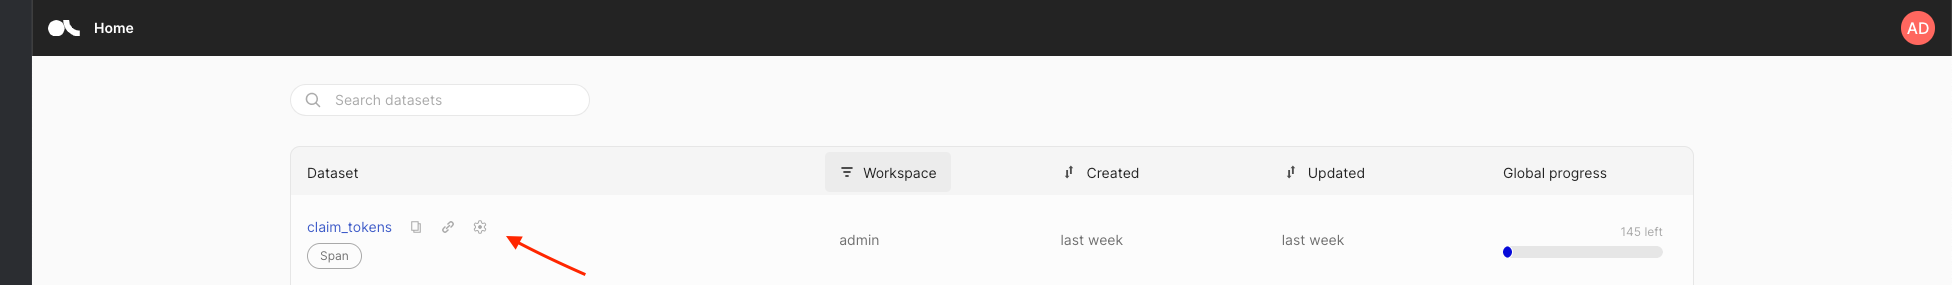

In [ ]:
def display_image(filename): display(Image(filename=filename))

display_image('/content/images/argilla_ds_list_settings.png')

 The Fields tab of settings screen lists down fields we configured while creating the dataset using Python SDK.

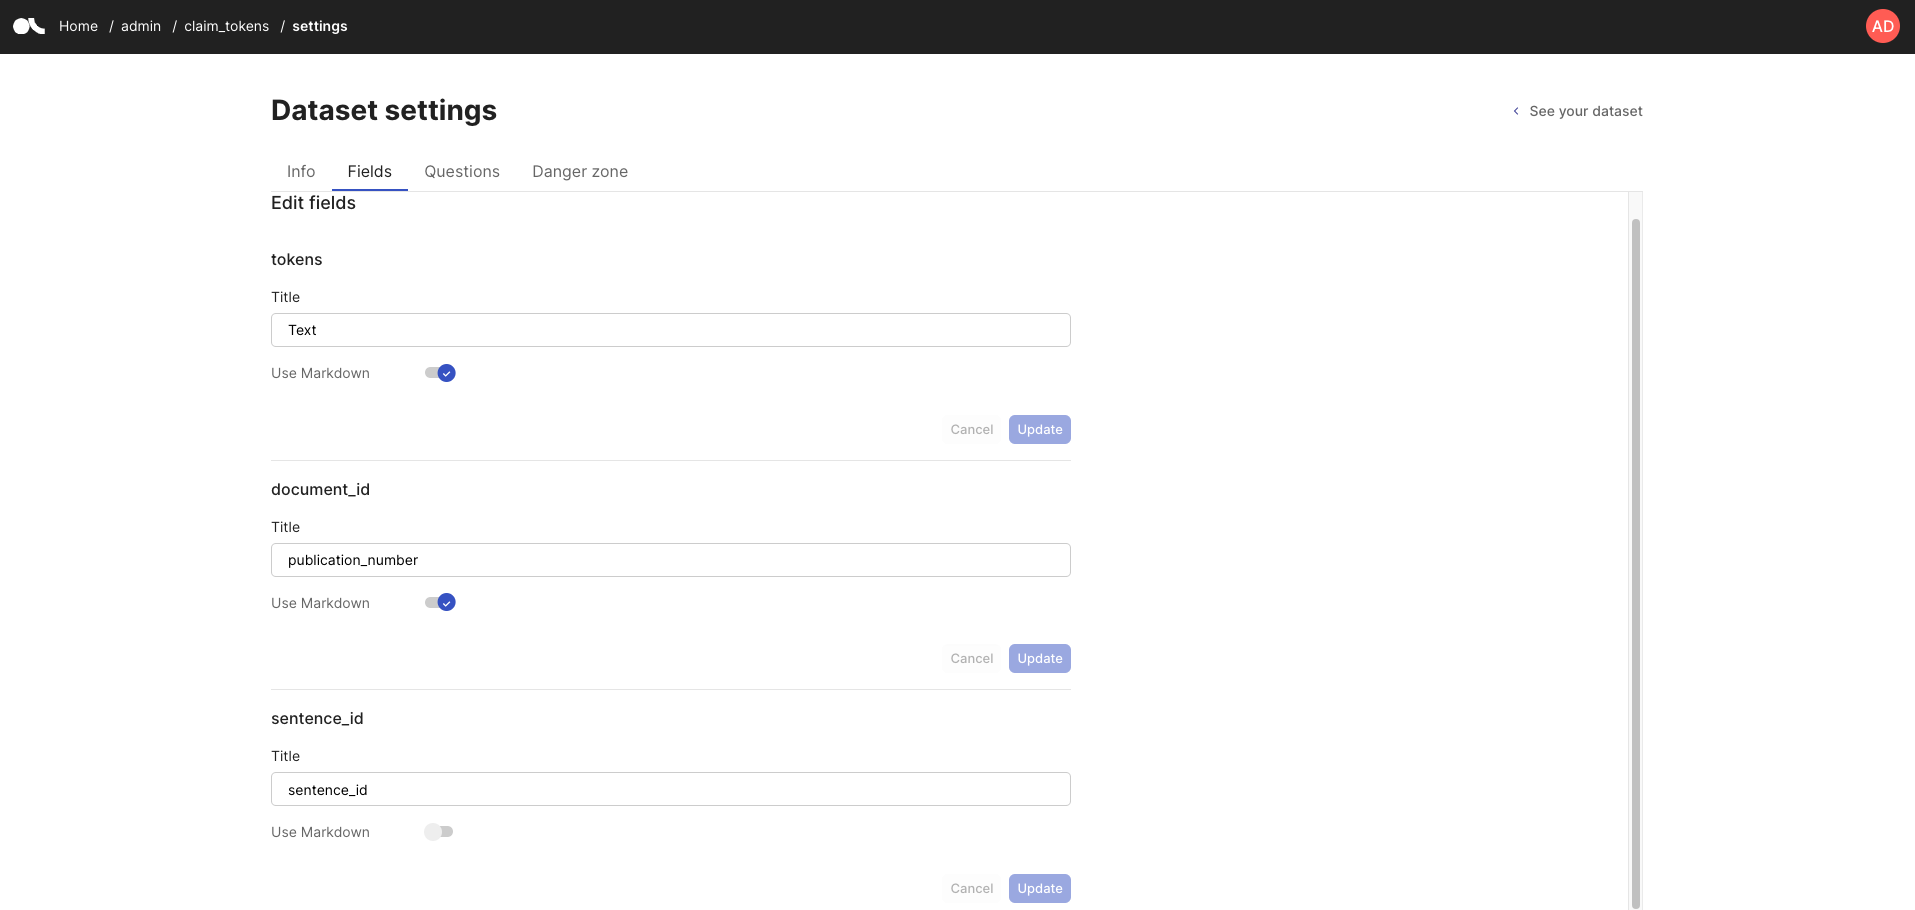

In [ ]:
display_image('/content/images/argilla_ds_settings.png')

#### Step 5: Insert records to the Argilla datasets

Data preparation notebook can be found [here](https://www.kaggle.com/code/boredmgr/claim-sampling)

In [ ]:
claims = pd.read_csv("/content/sample_publications.csv")
claims.head(2)

,publication_number,sequence_id,tokens
0,US-4444749-A,0,A shampoo comprising an aqueous solution of an...
1,US-4444749-A,1,A shampoo comprising an aqueous solution of an...


Here we are reading rows of the csv and mapping them to the fields we created during Argilla dataset configuration step.

In [ ]:
## We upload a csv with three columns : tokens, publication_number, sequence_id

publication_df = pd.read_csv("/content/sample_publications.csv")
## Convert dataframe rows to Argilla Records
records = [
    rg.Record(
        fields=
            {"tokens": "".join(row["tokens"])
            ,'document_id':str(row['publication_number'])
            ,'sentence_id':str(row['sequence_id'])
            })
  for _,row in publication_df.iterrows()
  ]
  ## Store Argilla records to Argilla Dataset
rg_dataset.records.log(records)

DatasetRecords: The provided batch size 256 was normalized. Using value 149.

Sending records...: 100%|██████████| 1/1 [00:00<00:00,  1.71batch/s]


DatasetRecords(Dataset(id=UUID('a187cdad-175e-4d87-989f-a529b9999bde') inserted_at=datetime.datetime(2024, 7, 28, 7, 23, 59, 902685) updated_at=datetime.datetime(2024, 7, 28, 7, 24, 1, 901701) name='claim_tokens' status='ready' guidelines='Classify individual tokens according to the specified categories, ensuring that any overlapping or nested entities are accurately captured.' allow_extra_metadata=False workspace_id=UUID('fd4fc24c-fc1f-4ffe-af41-d569432d6b50') last_activity_at=datetime.datetime(2024, 7, 28, 7, 24, 1, 901701) url=None))

Once, we have records pushed to Argilla Dataset, the UI will render the records and the labels for the annotator to annotate the text.

Check the screeshots below.

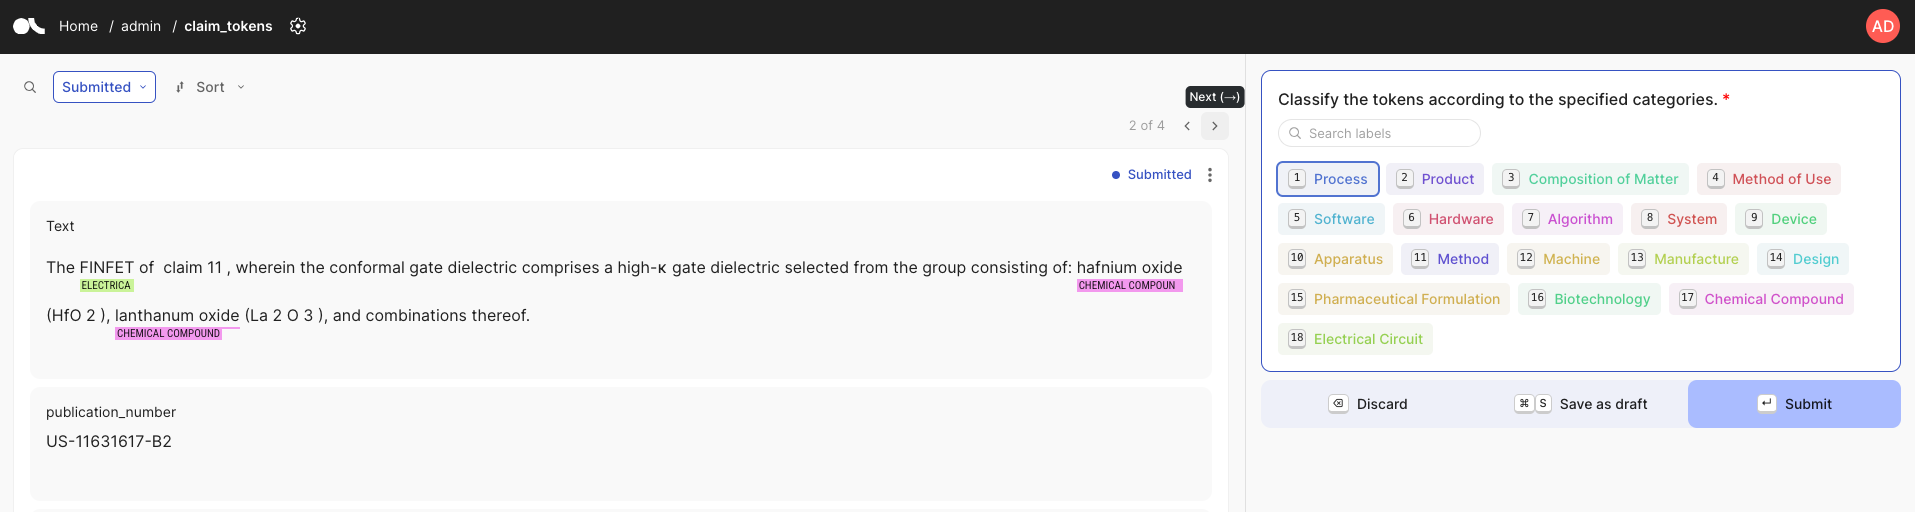

In [ ]:
display_image("/content/images/annotation_screen.png")

#### Step 6 : Annotate tokens in every records with appropriate labels.
Login to the Argilla UI and start annotating.

Argilla UI : `https://huggingface.co/spaces/<hf-username>/<hf-space-name>`

username : `admin`

password : `12345678`



> After annotating the data , we will have to convert Argilla Dataset to HuggingFace dataset in order to use HuggingFace AutoTrain for fine-tuning the model. HF AutoTrain allows training on CSV data too which can be uploaded from AutoTrain UI. But for this tutorial we will use Huggingface dataset.



## Argilla Dataset to HuggingFace Dataset

#### Step 1: Load our annotated dataset

In [ ]:
rg_dataset = client.datasets("claim_tokens")

#### Step 2 : Filter the rows / records which are annotated.
For us to have quick iterations on annotation and training, we should be able to annotate a few records and train our model.We can achieve it by using the [query/filter](https://docs.argilla.io/latest/how_to_guides/query/) functionality of Argilla Dataset.

Using [`rg.Query()`](https://docs.argilla.io/latest/how_to_guides/query/) api we can filter the records which are annotated for preparing our training dataset.

In [ ]:
status_filter = rg.Query(filter=rg.Filter(("response.status", "==", "submitted")))

submitted = rg_dataset.records(status_filter).to_list(flatten=True)
submitted[0]

{'id': '01e9b4bb-9c98-4cec-acea-dd686cddf5f0',
 'status': 'pending',
 '_server_id': '0b6f16f3-c3dc-4947-ac77-8b65002bf350',
 'tokens': 'The FINFET of  claim 11 , wherein the conformal gate dielectric comprises a high-κ gate dielectric selected from the group consisting of: hafnium oxide (HfO 2 ), lanthanum oxide (La 2 O 3 ), and combinations thereof.',
 'document_id': 'US-11631617-B2',
 'sentence_id': '14',
 'span_label.responses': [[{'label': 'Electrical Circuit',
    'start': 4,
    'end': 10},
   {'label': 'Chemical Compound', 'start': 138, 'end': 151},
   {'label': 'Chemical Compound', 'start': 162, 'end': 177}]],
 'span_label.responses.users': ['4e9588d6-e2d6-450d-82c6-b33324d94708'],
 'span_label.responses.status': ['submitted']}

The annotated dataset cannot be fed as it is to the model for training. For token-classification task, we will have to make our data that adheres to the structure as described below.
- Dataset Structure: The dataset should typically have two main columns:
    - `tokens`: A list of words/tokens for each example.
    - `ner_tags`: A list of corresponding labels for each token. The labels must follow the [IOB labelling scheme](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)).
- Label Encoding: The labels should be integers, with each integer corresponding to a specific named entity tag.
Below functions will allow us to convert our Argilla dataset to the required dataset structure.


In [ ]:
def get_iob_tag_for_token(token_start:int, token_end:int, ner_spans:List[Dict[str, Union[int, str]]]) -> str:
    """
    Determine the IOB tag for a given token based on its position within NER spans.

    Args:
        token_start (int): The start index of the token in the text.
        token_end (int): The end index of the token in the text.
        ner_spans (List[Dict[str, Union[int, str]]]): A list of dictionaries containing NER span information.
            Each dictionary should have 'start', 'end', and 'label' keys.

    Returns:
        str: The IOB tag for the token. 'B-' prefix for the beginning of an entity,
             'I-' for inside an entity, or 'O' for outside any entity.
    """
    for span in ner_spans:
        if token_start >= span["start"] and token_end <= span["end"]:
            if token_start == span["start"]:
                return f"B-{span['label']}"
            else:
                return f"I-{span['label']}"
    return "O"


def extract_ner_tags(text:str, responses:List[Dict[str, Union[int, str]]]):
    """
    Extract NER tags for tokens in the given text based on the provided NER responses.

    Args:
        text (str): The input text to be tokenized and tagged.
        responses (List[Dict[str, Union[int, str]]]): A list of dictionaries containing NER span information.
            Each dictionary should have 'start', 'end', and 'label' keys.

    Returns:
        List[str]: A list of IOB tags corresponding to each non-whitespace token in the text.
    """
    tokens = re.split(r"(\s+)", text)
    ner_tags = []
    current_position = 0
    for token in tokens:
        if token.strip():
            token_start = current_position
            token_end = current_position + len(token)
            tag = get_iob_tag_for_token(token_start, token_end, responses)
            ner_tags.append(tag)
        current_position += len(token)
    return ner_tags

ner_tags = extract_ner_tags(submitted[0]['tokens'], submitted[0]['span_label.responses'][0])
if DEBUG: print(ner_tags)

#### Step 3: Get tokens and theirs respective annotations

In [ ]:
def get_tokens_ner_tags(annotated_rows) -> Tuple[List[List[str]], List[List[str]]]:
    """
    Extract tokens and their corresponding NER tags from annotated rows.

    This function processes a list of annotated rows, where each row contains
    tokens and span labels. It splits the tokens and extracts NER tags for each token.

    Args:
        annotated_rows (List[Dict[str, Union[str, List[Dict[str, Union[int, str]]]]]]):
            A list of dictionaries, where each dictionary represents an annotated row.
            Each row should have a 'tokens' key (str) and a 'span_label.responses' key
            (List[Dict[str, Union[int, str]]]).

    Returns:
        Tuple[List[List[str]], List[List[str]]]: A tuple containing two elements:
            1. A list of token lists, where each inner list represents tokens for a row.
            2. A list of NER tag lists, where each inner list represents NER tags for a row.
    """
    tokens = []
    ner_tags = []
    for idx,row in enumerate(annotated_rows):
        tags = extract_ner_tags(row["tokens"], row["span_label.responses"][0])
        tks = row["tokens"].split()
        tokens.append(tks)
        ner_tags.append(tags)
    return tokens, ner_tags
train_tokens, train_ner_tags = get_tokens_ner_tags(submitted[:1])
validation_tokens, validation_ner_tags = get_tokens_ner_tags(submitted[1:2])


##### Vibe Check
Its always good to check our data after a few operations. This will help us understand and debug if the output of every steps results in desired output.

In [ ]:
if DEBUG: print(train_tokens[0][10:]),print(train_ner_tags[0][10:])

In [ ]:
if DEBUG: print(validation_tokens[0][10:]),print(validation_ner_tags[0][10:])

As we are trying to have our data creation and model training pipeline working, for simplicity , I have dealing with one record each for training and validation.

#### Step 4: Map labels (tags) to integers

In [ ]:
def mapped_ner_tags(ner_tags: List[List[str]]) -> List[List[int]]:
    """
    Convert a list of NER tags to their corresponding integer IDs.
    This function takes a list of lists containing string NER tags, creates a unique mapping
    of these tags to integer IDs, and then converts all tags to their respective IDs.
    Args:
        ner_tags (List[List[str]]): A list of lists, where each inner list contains string NER tags.
    Returns:
        List[List[int]]: A list of lists, where each inner list contains integer IDs
                         corresponding to the input NER tags.
    Example:
        >>> ner_tags = [['O', 'B-PER', 'I-PER'], ['O', 'B-ORG']]
        >>> mapped_ner_tags(ner_tags)
        [[0, 1, 2], [0, 3]]
    Note:
        The mapping of tags to IDs is created based on the unique tags present in the input.
        The order of ID assignment may vary between function calls if the input changes.
    """
    labels = list(set([item for sublist in ner_tags for item in sublist]))
    id2label = {i: label for i, label in enumerate(labels)}
    label2id = {label: id_ for id_, label in id2label.items()}
    mapped_ner_tags = [[label2id[label] for label in ner_tag] for ner_tag in ner_tags]
    return mapped_ner_tags

In [ ]:
def get_labels(ner_tags: List[List[str]]) -> List[str]:
    """
    Extract unique labels from a list of NER tag sequences.
    This function takes a list of lists containing NER tags and returns a list of unique labels
    found across all sequences.

    Args:
        ner_tags (List[List[str]]): A list of lists, where each inner list contains string NER tags.
    Returns:
        List[str]: A list of unique NER labels found in the input sequences.
    Example:
        >>> ner_tags = [['O', 'B-PER', 'I-PER'], ['O', 'B-ORG', 'I-ORG'], ['O', 'B-PER']]
        >>> get_labels(ner_tags)
        ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG']
    Note:
        The order of labels in the output list is not guaranteed to be consistent
        between function calls, as it depends on the order of iteration over the set.
    """
    return list(set([item for sublist in ner_tags for item in sublist]))

#### Step 5: Argilla Dataset to HuggingFace Dataset
We now have our data in a structure as required for token classification dataset. We will just have to create a Hugging Face Dataset.

In [ ]:
train_labels = get_labels(train_ner_tags)
validation_labels = get_labels(validation_ner_tags)
labels = list(set(train_labels + validation_labels))
if DEBUG: print(labels)
features = Features({
    "tokens": Sequence(Value("string")),
    "ner_tags": Sequence(ClassLabel(num_classes=len(labels), names=labels))
})
train_records = [
    {
        "tokens": token,
        "ner_tags": ner_tag,
    }
    for token, ner_tag in zip(train_tokens, mapped_ner_tags(train_ner_tags))
]
validation_records = [
    {
        "tokens": token,
        "ner_tags": ner_tag,
    }
    for token, ner_tag in zip(validation_tokens, mapped_ner_tags(validation_ner_tags))
]
span_dataset = DatasetDict(
    {
        "train": Dataset.from_list(train_records,features=features),
        "validation": Dataset.from_list(validation_records,features=features),
    }
)
if DEBUG: print(span_dataset)

In [ ]:
# assertion to verify if train split conforms the dataset structure requirement for training
assert span_dataset['train'].features['ner_tags'].feature.names is not None

#### Step 6: Push dataset to Hugginface Hub

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
span_dataset.push_to_hub("bikashpatra/sample_claims_annotated_hf")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/bikashpatra/sample_claims_annotated_hf/commit/e9faaa35dda423fcb2bccde9f19cbacd832af80a', commit_message='Upload dataset', commit_description='', oid='e9faaa35dda423fcb2bccde9f19cbacd832af80a', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
if DEBUG:
    ds = load_dataset("bikashpatra/sample_claims_annotated_hf")
    print(ds)

In [ ]:
if DEBUG: print(ds['train'][0])

## Model Fine-tuning using AutoTrain
Huggingface [AutoTrain](https://huggingface.co/autotrain) is a simple tool to train model without writing a any code. We can use autotrain to fine-tune for a range of tasks like token-classification, text-generation, Image Classification and many more. In order to use AutoTrain, we will have to first create an instance of AutoTrain in HF space. Use the [create space](https://huggingface.co/new-space?template=autotrain-projects%2Fautotrain-advanced) link. For space SDK choose Docker and select AutoTrain as Docker template. We need to choose a hardware to train our model. Check the screenshots for a quick reference


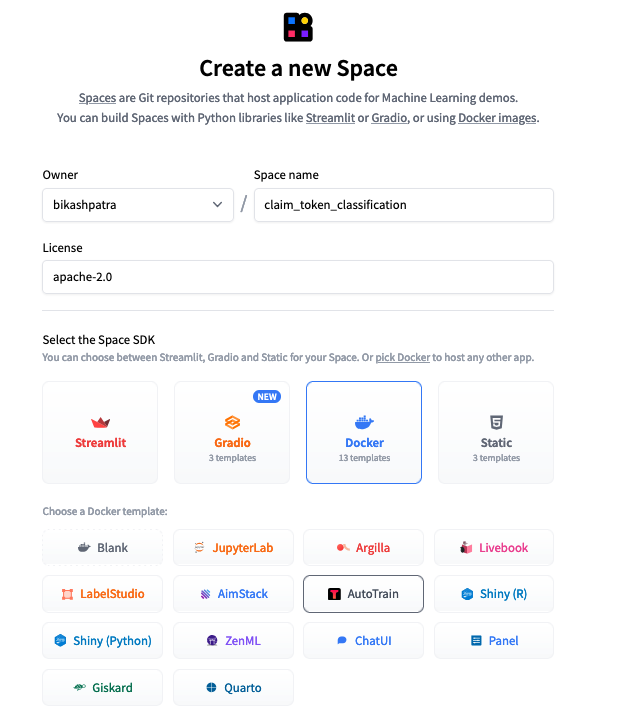

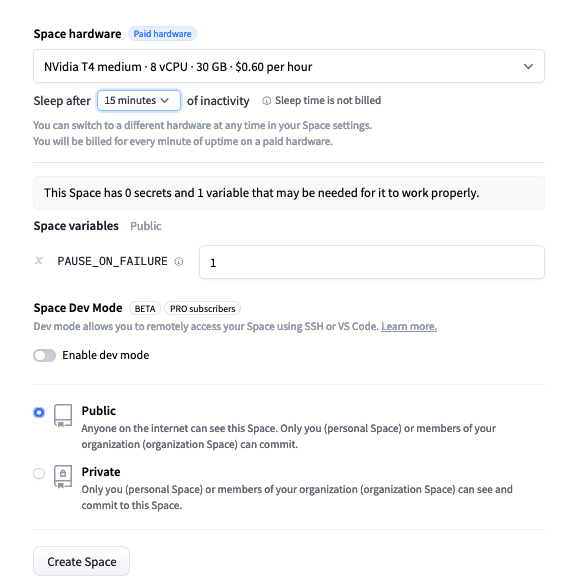

In [ ]:
display_image("/content/images/autotrain_screen1.png")
display_image("/content/images/autotrain_screen2.png")

### Using AutoTrain UI

After space creation, AutoTrain UI will allow us to select from range of tasks. We will have to configure our trainer on the AutoTrain UI.
1. We will select Token classification as our task.
2. For our tutorial we will fine-tune `google-bert/bert-base-uncased`. We can choose any model from the list.
3. For DataSource select `Hugging Face Hub` which will give us a text box to fill in the dataset which we want to use for fine-tuning. We will use the dataset we pushed to Huggingface hub. I will be using the dataset that I pushed to huggingface hub `bikashpatra/claims_annotated_hf`
4. Enter the keys for `train` and `validation` split.
5. Under Column Mapping , enter the columns which store the tokens and tags. In my dataset , tokens are stored in `tokens` column and labels are stored in `ner_tags` column.
With the above 5 inputs, we can trigger `Start Training` and AutoTrain will take care of fine-tuning the base model on our dataset.

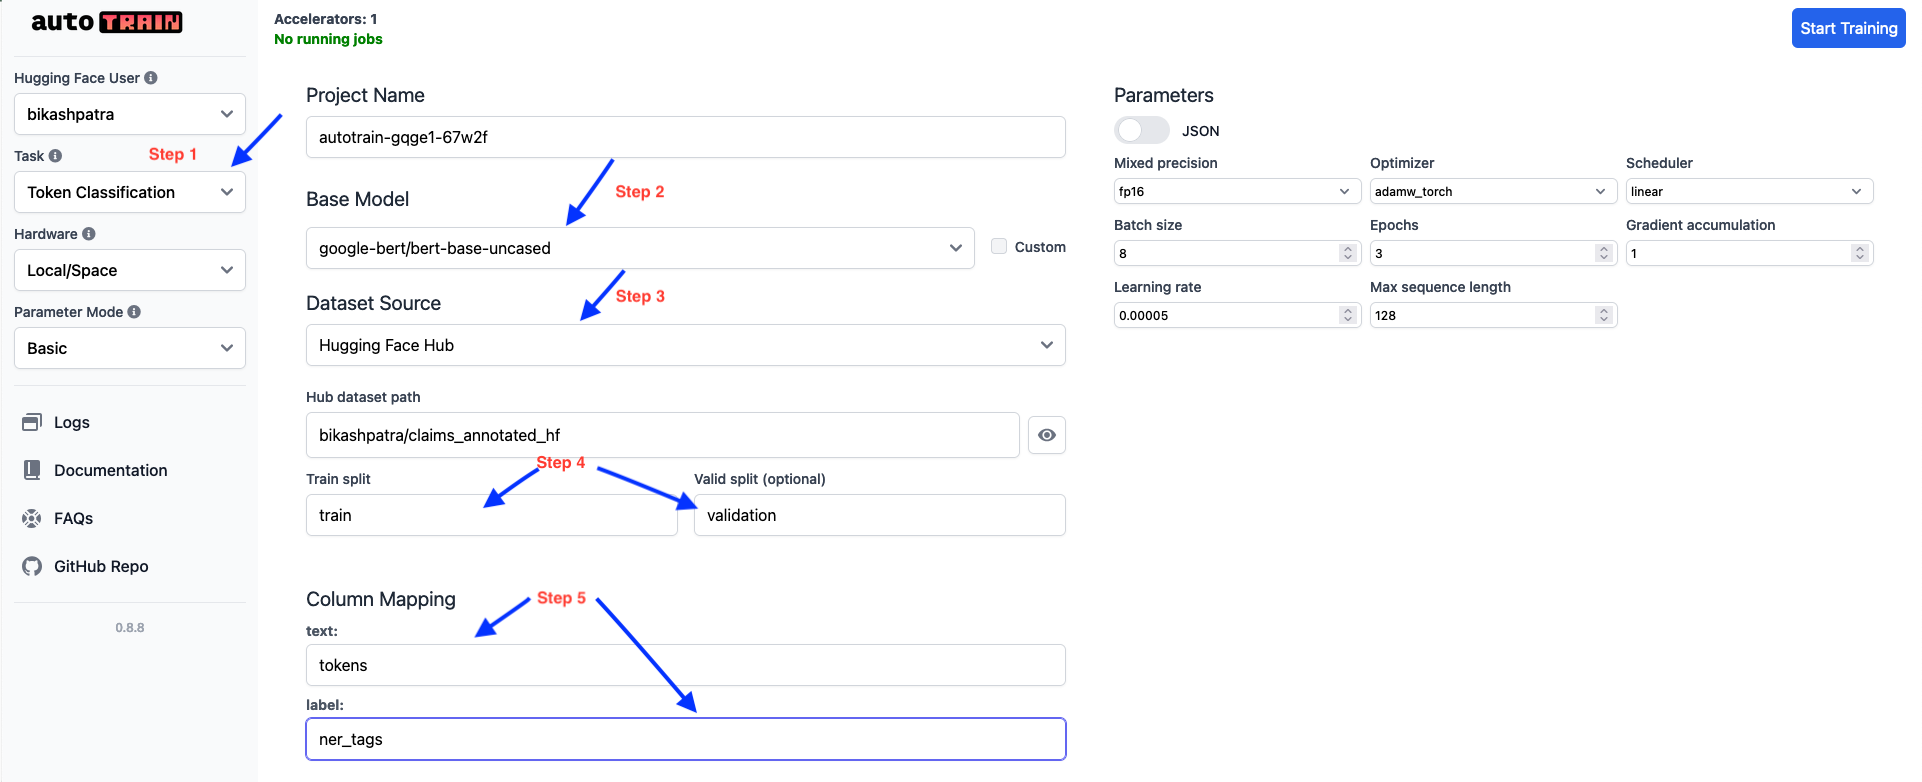

In [ ]:
display_image("/content/images/autotrain_ui.png")

### Using AutoTrain CLI

In [ ]:
# for this cell to work, you will have to store HF_TOKEN as secret in colab notebook.
os.environ['TOKEN'] = userdata.get('HF_TOKEN')

In [ ]:
!autotrain token-classification --train \
           --username "bikashpatra" \
           --token $TOKEN \
           --backend "spaces-a10g-small" \
           --project-name "claims-token-classification" \
           --data-path "bikashpatra/sample_claims_annotated_hf" \
           --train-split "train" \
           --valid-split "validation" \
           --tokens-column "tokens" \
           --tags-column "ner_tags" \
           --model "distilbert-base-uncased" \
           --lr "2e-5" \
           --log "tensorboard" \
           --epochs "10" \
           --weight-decay "0.01" \
           --warmup-ratio "0.1" \
           --max-seq-length "256" \
           --mixed-precision "fp16" \
           --push-to-hub

INFO     | 2024-08-08 04:22:38 | autotrain.cli.run_token_classification:run:179 - Running Token Classification
WARNING  | 2024-08-08 04:22:38 | autotrain.trainers.common:__init__:180 - Parameters supplied but not used: backend, deploy, config, train, func, version, inference
INFO     | 2024-08-08 04:22:40 | autotrain.cli.run_token_classification:run:185 - Job ID: bikashpatra/autotrain-claims-token-span-marker


AutoTrain automatically creates huggingface space for us and triggers the training job. Link to the space created is `https://huggingface.co/spaces/$JOBID where JOBID is the value that we get from the logs of autotrain cli command.


If the model training executes without any errors, our model is available with the value we provided to `--project-name`. In the above example it was `claims-token-classification`

## Inference
With all the hardwork done, we have our model trained our custom dataset.We can use our trained model to predict labels for un-annotated rows.
We will use [HF Pipelines](https://huggingface.co/docs/transformers/main_classes/pipelines) api. Pipelines are easy to use abstraction to load model and execute inference on un-seen data.In context of this tutorial _inference on un-seen text_ means predicting labels for tokens in un-annotated text.

In [ ]:
# Classify a sample text
claims_text = """
The FINFET of  claim 11 , wherein the conformal gate dielectric comprises a high-κ gate dielectric selected from
the group consisting of: hafnium oxide (HfO 2 ), lanthanum oxide (La 2 O 3 ), and combinations thereof.
"""
classifier = pipeline("token-classification", model="bikashpatra/claims-token-classification")
preds = classifier(claims_text)

In [ ]:
# The labels used for training the model.
if DEBUG: print(f"labels : \n {pipe.model.config.id2label}")

## Push predictions to Argilla Dataset
Using [`rg.Query`](https://docs.argilla.io/latest/how_to_guides/query/) api we filter un-annotated data and predict tokens.

The filter `rg.Filter(("response.status","==","pending"))` allows us to create a Argilla filter which we pass to [`rg.Query`](https://docs.argilla.io/latest/how_to_guides/query/) to get us all the records in Argilla dataset which has not been annotated.

In [ ]:
# Create a filter query to get only `pending` records in argilla dataset.
status_filter = rg.Query(filter=rg.Filter(("response.status", "==", "pending")))

submitted = rg_dataset.records(status_filter).to_list(flatten=True)
claims = random.sample(submitted,k=10) # pick 10 random samples.

spans = pipe(claims[0]['tokens'])

#### Vibe check

In [ ]:
if DEBUG: print(claims[0]['tokens']),print(spans)

### Helper function to predict the spans

In [ ]:
def predict_spanmarker(pipe:TokenClassificationPipeline,text: str):
    """
    Predict span markers for the given text using the provided pipeline.
    Args:
        pipe (TokenClassificationPipeline): A pipeline object for token classification.
        text (str): The input text for which span markers are to be predicted.
    Returns:
        List[Dict[str, Union[int, str]]]: A list of dictionaries containing the predicted span markers.
        Each dictionary should have 'start', 'end', and 'label' keys.
    """
    markers = pipe(text)
    spans = [
        {"label": marker["entity"][2:], "start": marker["start"], "end": marker["end"]}
        for marker in markers if marker["entity"] != "O"
        ]
    return spans

In [ ]:
updated_data=[
    {
        "span_label": predict_spanmarker(pipe=pipe, text=sample['tokens']),
        "id": sample["id"],
    }
    for sample in claims
]

### Insert records to Argilla Dataset.

In [ ]:
rg_dataset.records.log(records=updated_data)

DatasetRecords: The provided batch size 256 was normalized. Using value 10.

Sending records...: 100%|██████████| 1/1 [00:00<00:00,  1.15batch/s]


DatasetRecords(Dataset(id=UUID('a187cdad-175e-4d87-989f-a529b9999bde') inserted_at=datetime.datetime(2024, 7, 28, 7, 23, 59, 902685) updated_at=datetime.datetime(2024, 7, 28, 7, 35, 55, 80617) name='claim_tokens' status='ready' guidelines='Classify individual tokens according to the specified categories, ensuring that any overlapping or nested entities are accurately captured.' allow_extra_metadata=False distribution=None workspace_id=UUID('fd4fc24c-fc1f-4ffe-af41-d569432d6b50') last_activity_at=datetime.datetime(2024, 7, 28, 7, 35, 55, 80181)))

The records we update here are stored as [`suggestions`](https://docs.argilla.io/latest/reference/argilla/records/suggestions/) and not [`responses`](https://docs.argilla.io/latest/reference/argilla/records/responses/). Responses in the context of this tutorial are created when annotator saves a annotation.Suggestions are labels predicted by model.Therefore, the records we updated here will have `response.status` as `pending` and not `submitted`. This will allow us/annotators to check the predicted labels and accept or reject model predictions.

If we want to accept model predicted annotations for tokens in a text, we may save the [`suggestions`] as [`responses`], else we will have to add / remove / edit labels applied to tokens.

## Conclusion

In this comprehensive tutorial, we've explored a complete workflow for data annotation and model fine-tuning. We began by setting up an [Argilla](https://argilla.io/) instance on [Hugging Face Spaces](https://huggingface.co/spaces), providing a robust platform for data management. We then configured and created a dataset within our Argilla instance, leveraging its user-friendly interface to manually annotate a subset of records.

We continued as we exported the high-quality annotated data to a Hugging Face [dataset](https://huggingface.co/datasets), bridging the gap between annotation and model training. We then demonstrated the power of transfer learning by fine-tuning a `distilbert-base-uncased` model on this curated dataset using Hugging Face's [AutoTrain](https://huggingface.co/autotrain), a tool that simplifies the complexities of model training.

The workflow came full circle as we applied our fine-tuned model to annotate the remaining unlabeled records in the Argilla dataset, showcasing how machine learning can accelerate the annotation process. This tutorial should provide a solid foundation for implementing an iterative annotation and fine-tuning pipeline while illustrating the synergy between human expertise and machine learning capabilities.

This iterative approach allows for continuous improvement, making it an invaluable tool for tackling a wide range of natural language processing tasks efficiently and effectively.